## Enunciado

> Supongamos un proyecto para pintar la fachada de un edificio de planta cuadrada. Cada fachada se estima que tarde dos días en pintarse y conlleve un gasto de 2000 euros. Las fachadas se pintan consecutivamente. Hoy es el final del día 6 y el trabajo se encuentra de la siguiente manera:
>    - Fachada 1: Acabado en el día 2, 2000 euros.
>    - Fachada 2: Acabado en el día 5, 2400 euros.
>    - Fachada 3: 50% acabado, 1200 euros.
>    - Fachada 4: sin empezar.
>     
> El coste final estimado por el contratista, LRE, es de 8200 euros.
> Se pide realizar un analisis del valor ganado del proyecto a fecha actual (fin del día 6). Se admite un error de precisión de 0.02.
> De las fórmulas estudiadas para el coste estimado final por el promotor utilice: EAC=BAC/CPI.


In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph, EarnedValue



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import numpy as np

datos_enunciado = pd.DataFrame([
#     actividad,   precedentes,  duracion,  coste_planificado,     coste_real,  duracion_real,  realizado
     ('Fachada_1', '---      ',       2,            2000,              2000,          2,       100,   ),
     ('Fachada_2', 'Fachada_1',       2,            2000,              2400,          3,       100,   ),
     ('Fachada_3', 'Fachada_2',       2,            2000,              1200,          1,        50,   ),
     ('Fachada_4', 'Fachada_3',       2,            2000,                 0,          0,           0,   ),
] ,columns=['actividad', 'precedentes', 'duracion',  'coste_planificado', 'coste_real', 'duracion_real',
            'realizado']).set_index('actividad')
datos_enunciado

,precedentes,duracion,coste_planificado,coste_real,duracion_real,realizado
actividad,,,,,,
Fachada_1,---,2,2000,2000,2,100
Fachada_2,Fachada_1,2,2000,2400,3,100
Fachada_3,Fachada_2,2,2000,1200,1,50
Fachada_4,Fachada_3,2,2000,0,0,0


### Resolución


En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [3]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,Fachada_1,Fachada_2,Fachada_3,Fachada_4
activities,,,,
Fachada_1,,,,
Fachada_2,True,,,
Fachada_3,,True,,
Fachada_4,,,True,


La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

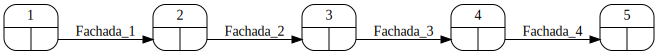

In [4]:
proyecto = prelaciones.create_project()
proyecto.pert()

#### Gantt Valor Planificado

In [5]:
vg = EarnedValue(proyecto)


In [6]:
datos_proyecto['duracion'] = datos_proyecto['duracion'].astype(float)
gantts = vg.calcula_gantts(data=datos_proyecto,
                           planned_durations_label = 'duracion',
                           actual_durations_label='duracion_real',
                           PV_label='coste_planificado',
                           AC_label='coste_real',
                           percentage_complete_label='realizado',
                          )

In [7]:
gantts['Gantt_PV']

,1,2,3,4,5,6,7,8,Total
Fachada_1,1000.000000,1000.000000,,,,,,,2000.000000
Fachada_2,,,1000.000000,1000.000000,,,,,2000.000000
Fachada_3,,,,,1000.000000,1000.000000,,,2000.000000
Fachada_4,,,,,,,1000.000000,1000.000000,2000.000000
Total,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,8000.000000
Acumulado,1000.000000,2000.000000,3000.000000,4000.000000,5000.000000,6000.000000,7000.000000,8000.000000,


#### Gantt Valor Ganado

In [8]:
gantts['Gantt_EV']

,1,2,3,4,5,6,Total
Fachada_1,1000.000000,1000.000000,,,,,2000.000000
Fachada_2,,,666.666667,666.666667,666.666667,,2000.000000
Fachada_3,,,,,,1000.000000,1000.000000
Total,1000.000000,1000.000000,666.666667,666.666667,666.666667,1000.000000,5000.000000
Acumulado,1000.000000,2000.000000,2666.666667,3333.333333,4000.000000,5000.000000,


#### Gantt Coste Real

In [9]:
gantts['Gantt_AC']

,1,2,3,4,5,6,Total
Fachada_1,1000.000000,1000.000000,,,,,2000.000000
Fachada_2,,,800.000000,800.000000,800.000000,,2400.000000
Fachada_3,,,,,,1200.000000,1200.000000
Total,1000.000000,1000.000000,800.000000,800.000000,800.000000,1200.000000,5600.000000
Acumulado,1000.000000,2000.000000,2800.000000,3600.000000,4400.000000,5600.000000,


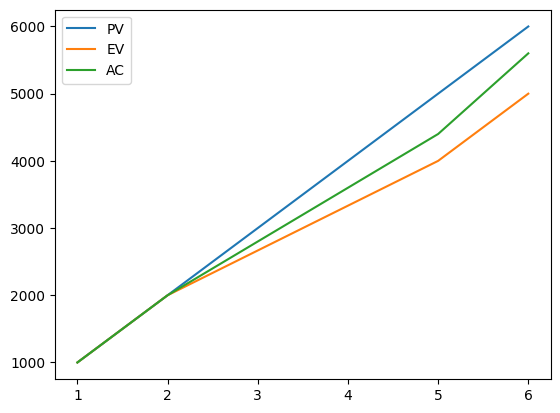

In [10]:
acumulados = gantts['acumulados']
acumulados.plot();

In [11]:
acumulados.tail(1)

,PV,EV,AC
6,6000.0,5000.0,5600.0


#### Cálculo de parámetros diversos

In [12]:
EV = acumulados.tail(1)['EV']
EV

,EV
6,5000.0


In [13]:
AC = acumulados.tail(1)['AC']
AC

,AC
6,5600.0


In [14]:
PV = acumulados.tail(1)['PV']
PV

,PV
6,6000.0


In [15]:
CPI = EV/AC
CPI

,0
6,0.892857


In [16]:
SPI = EV/PV
SPI

,0
6,0.833333


In [17]:
BAC = datos_enunciado.loc[:, 'coste_planificado'].sum()
BAC

8000

In [18]:
EAC = BAC / CPI
EAC

,0
6,8960.0


In [19]:
CV = EV - AC
CV

,0
6,-600.0


In [20]:
CV_por_ciento = CV/EV *100
CV_por_ciento

,0
6,-12.0


In [21]:
SV = EV - PV
SV

,0
6,-1000.0


In [22]:
SV_por_ciento = SV/PV *100
SV_por_ciento

,0
6,-16.666667


In [23]:
VAC = BAC - EAC
VAC

,0
6,-960.0


In [24]:
PC = EV / BAC
PC

,EV
6,0.625


In [25]:
PS = AC / BAC
PS

,AC
6,0.7


In [26]:
PP = PV / BAC
PP

,PV
6,0.75


In [27]:
TCPI_BAC = (BAC - EV)/(BAC - AC)
TCPI_BAC

,0
6,1.25


In [28]:
TCPI_EAC = (BAC - EV)/(EAC - AC)
TCPI_EAC

,0
6,0.892857


In [29]:
LRE = 8200
TCPI_LRE = (BAC - EV)/(LRE - AC)
TCPI_LRE

,0
6,1.153846


La diferencia de rendimiento en costes indica que el LRE proporcionado no es verosimil.